Data loaded successfully.
DATA PREPROCESSING
Data preprocessing completed successfully.
----------------------------------------------------------------------------------------------------
REGRESSION MODEL: ELASTICNET WITH HYPERPARAMETER HEATMAP


/var/folders/p3/rf4qqwbj5td08r07369s000r0000gn/T/ipykernel_47266/3687217071.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_copy[col] = data_copy[col].fillna(data_copy[col].mode()[0])


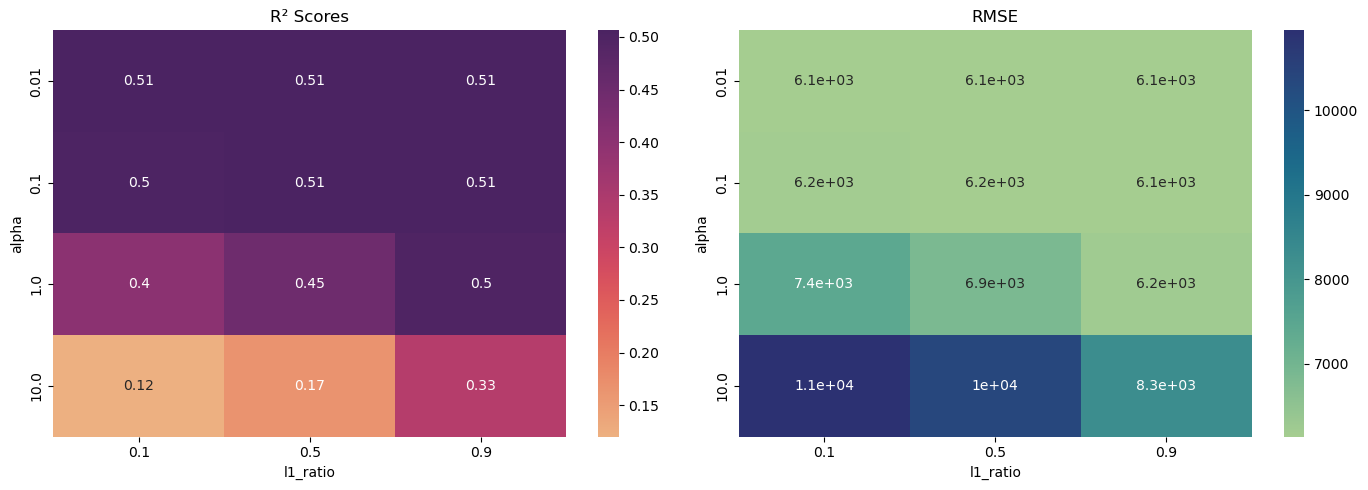

<Figure size 640x480 with 0 Axes>

In [15]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score



#Load the dataset
import pandas as pd
data = pd.read_csv('../Data/heart_disease_uci.csv')
if data is not None:
    print("Data loaded successfully.")


#DTA EXPLORATION
# #check the data types
# print(df.dtypes)
# # Check for missing values
# print(data.isnull().sum())

#DATA PREPROCESSING
print("DATA PREPROCESSING")
'''
Data Preprocessing Steps:
1. Drop columns with high missing values (>35% missing values)
2. impute missing values:
    - Numerical columns: fill with mean using KNNImputer
    - Categorical columns: fill with mode
3. Drop duplicates
4. Convert categorical columns to numerical using OneHotEncoder (chatGPT, 2025)
5. Fill any remaining NaN values (if any) after encoding 
'''

data_copy = data.copy()

#Drop columns that have high missing values (>35% missing values)(manually checked)
data_copy = data_copy.drop(columns=['slope','ca','thal'], errors='ignore')

# Identify numerical and categorical columns
numerical_col_name = data_copy.select_dtypes(include=['number']).columns
categorical_col_name = data_copy.select_dtypes(include=['object']).columns

#Fill missing values in numerical with mean and categorical with mode
#from lab6_rna.ipynb - source https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
from sklearn.impute import KNNImputer 
knn_imputer = KNNImputer(n_neighbors=5)
imputed_numerical = knn_imputer.fit_transform(data_copy[numerical_col_name])

data_copy[numerical_col_name] = imputed_numerical
for col in categorical_col_name:
    data_copy[col] = data_copy[col].fillna(data_copy[col].mode()[0])


#Drop duplicates
data_copy = data_copy.drop_duplicates()


# Convert categorical columns to numerical using OneHotEncoder (ChatGPT, 2025)
# (I used ChatGPT to help me find function to convert categorical columns to numerical, binary classification, and error handling)
# (source:https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)(I used this to learn how to use this function)
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(data_copy[categorical_col_name])

# Create a DataFrame with the encoded categorical columns
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_col_name))
# Concatenate the encoded categorical DataFrame with the original DataFrame (excluding original categorical columns)
data_copy = pd.concat([data_copy[numerical_col_name], encoded_df], axis=1)

# # Fill any remaining NaN values (if any) after encoding #ElasticNet does not handle NaN values
data_copy = data_copy.fillna(data_copy.mean(numeric_only=True))  # for numeric
data_copy = data_copy.fillna(0)  # fallback for any non-numeric leftovers

data_copy.to_csv('../Data/data_copy.csv', index=False)
if data.copy is not None:
    print("Data preprocessing completed successfully.")
# print(data_copy.columns)
# print(data_copy.dtypes)

print('--'*50)

#__________________
#REGRESSION MODEL
print("REGRESSION MODEL: ELASTICNET WITH HYPERPARAMETER HEATMAP")
'''
Train and evaluate ElasticNet regression model to predict cholesterol levels
    1. Set up the features and target variable
    2. Split the data into training and testing sets
    3. Standardize the features
    
create a heatmap to visualize the performance of ElasticNet regression with different hyperparameters, including alpha and l1_ratio.
1. set alphas values and l1-ratios  
2. create r2_scores and rmse_scores empty lists to store the results
3. create a loop to fit the model with each combination of alpha and l1_ratio
    a. fit the model
    b. predict the target variable
    c. calculate r2_score and rmse for each combination
    d. append the results to r2_scores and rmse_scores -> create a 2D list to store the results for each alpha and l1_ratio
4. plot the heatmaps for r2_scores and rmse_scores using seaborn
'''

#Set up the x and y 
x_reg = data_copy.drop(columns=['chol']) #everything else except 'chol' are features 
y_reg= data_copy['chol'] #chol is target variable

#Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_reg, y_reg, test_size = 0.2, random_state=42)

# Standardize features 
# (chatGPT, 2025. I used ChatGPT to help me find the function to standardize features)
#source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

alphas = [0.01, 0.1, 1.0, 10.0]
l1_ratios = [0.1, 0.5, 0.9]

r2_scores = []
rmse_scores = []

for alpha in alphas:
    r2_row = [] #to organize the results for each alpha for different l1_ratios
    rmse_row = []
    for l1 in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=42)
        model.fit(x_train_scaled, y_train)
        y_pred = model.predict(x_test_scaled)
        
        r2_row.append(r2_score(y_test, y_pred))
        rmse_row.append(mean_squared_error(y_test, y_pred))  # RMSE
        
    r2_scores.append(r2_row) #save the results for each alpha in the list according to l1_ratios
    rmse_scores.append(rmse_row)

# Plot heatmaps (source: https://seaborn.pydata.org/generated/seaborn.heatmap.html); I used ChaGPT to help me error handle the heatmap plotting
# color (source: https://matplotlib.org/stable/tutorials/colors/colormaps.html)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(r2_scores, annot=True, xticklabels=l1_ratios, yticklabels=alphas, ax=axes[0], cmap='flare')
axes[0].set_title('R² Scores')
axes[0].set_xlabel('l1_ratio')
axes[0].set_ylabel('alpha')

sns.heatmap(rmse_scores, annot=True, xticklabels=l1_ratios, yticklabels=alphas, ax=axes[1], cmap='crest')
axes[1].set_title('RMSE')
axes[1].set_xlabel('l1_ratio')
axes[1].set_ylabel('alpha')

plt.tight_layout()
plt.show()
# Save the heatmap as an image file
plt.savefig('../elasticnet_heatmap.png', dpi=300, bbox_inches='tight')


CLASSIFICATION MODEL: LOGISTIC REGRESSION AND K-NN CLASSIFIERS
Logistic Regression Performance:
Accuracy: 0.8261
F1 Score: 0.8476
ROC AUC: 0.8846


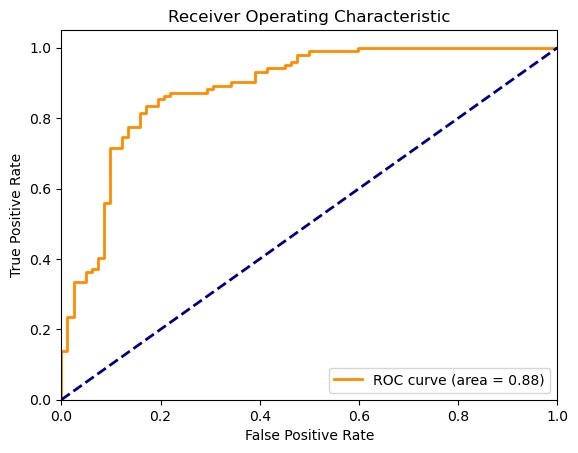

k-NN Classifier Performance:
ROC AUC: 0.8554


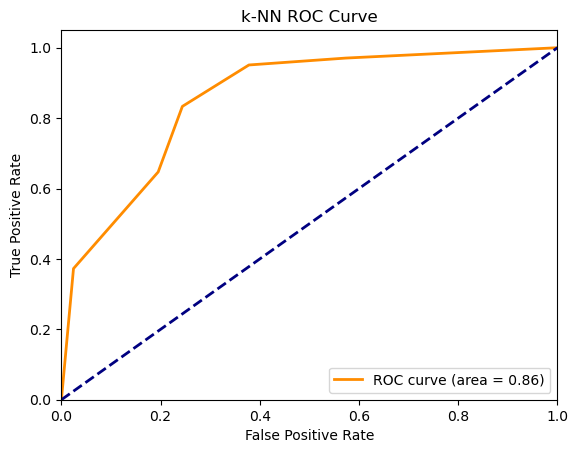

In [ ]:

#CLASSIFICATION MODEL
print("CLASSIFICATION MODEL: LOGISTIC REGRESSION AND K-NN CLASSIFIERS")
'''
Train and evaluate logistic regression and k_NN classifiers to predict hear disease presence as a binary classification task
A. Data Preprocessing Steps and Setup for Classification:
1.Convert the 'num' column to a binary classification target variable (presence of heart disease)
2. set up the features and target variable
3. Split the data into training and testing sets
4. Standardize the features
----------------
B. Compute metrics for logistic regression
1. Use accuracy, F1 score, AUROC, and AUPRC as evaluation metrics
2. Logistic Regression:
    Use LogisticRegression (penalty and solver) 
    -> model coefficients and performance (compute ROC and AUC scores)
3. k-NN Classifier:
    Use KNeighborsClassifier (n_neighbors, weights, and metric)
    -> model performance (compute ROC and AUC scores)
'''
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# A. Data Preprocessing Steps and Setup for Classification:
#conver 'num' column to binary classification target variable (Source: VS auto-code completion and ChatGPT, 2025)
data_copy['num'] = data_copy['num'].apply(lambda x: 1 if x > 0 else 0)  # Convert to binary classification (presence of heart disease)
# Check if the 'num' column is binary
if not data_copy['num'].isin([0, 1]).all():
    raise ValueError("The 'num' column is not binary. Please check the data preprocessing steps.")

# Set up the features and target variable for classification
x_class= data_copy.drop(columns=['num']) 
y_class = data_copy['num']  # 'target' = 'num' = is the binary classification target variable

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_class, y_class, test_size= 0.2, random_state=42)

# Standardize the features
 #source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#train a logistic regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train_scaled, y_train)

#predict probabilities
y_pred = log_reg_model.predict(x_test_scaled)
y_proba = log_reg_model.predict_proba(x_test_scaled)[:, 1]  # Get probabilities for the positive class



# B. Compute metrics for logistic regression
#compute metrics 
acc_log = accuracy_score(y_test, y_pred)
f1_log = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)


print("Logistic Regression Performance:")
print(f"Accuracy: {acc_log:.4f}")
print(f"F1 Score: {f1_log:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


#_____________________________
# Train a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_scaled, y_train)

# Predict probabilities
y_proba_knn = knn.predict_proba(x_test_scaled)[:, 1]  # Get probabilities for the positive class

#Compute ROC curve and ROC area
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
print("k-NN Classifier Performance:")
print(f"ROC AUC: {roc_auc_knn:.4f}")

#Plot ROC curve for k-NN
# Plot ROC curve
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('k-NN ROC Curve')
plt.legend(loc='lower right')
plt.show()


###NOTE: 
'''
All the codes used referenced from lab materials and scikit-learn website as they are new concepts for me. 
The pipelines of this assignment are written by me yet suggested codes were referenced from partial VS built-in auto-code completion and chatGPT.
ChatGPT, 2025 was used to help me find functions for OneHotEncoder, StandardScaler, and error handling for heatmap plotting (new concepts)
Plots were created using lab materials 
'''
